<a href="https://colab.research.google.com/github/Vinnie369/getting-started-with-python-in-colab-Vinnie369/blob/main/Kapitza_Pendulum_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [31]:
# import modules
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

## Define our equation of motion for pivot-drive pendulum

The equation of motion is:
$$ \theta'' + 2 \zeta \theta' + \left(\epsilon^2 - \alpha cos\tau \right)sin\theta = 0$$

Putting this in the form needed by the solver `solve_ivp`gives,

$$ \theta'' = - 2 \zeta \theta' - \left(\epsilon^2 - \alpha cos\tau \right)sin\theta$$

Note that $f' = \frac{df}{d\tau}$ with $\tau=\omega_d t$, a dimensionless time.

In [32]:
# define equation of motion
def pivot_driven_pendulum(tau, y, epsilon, alpha, zeta):
  """
  This function defines the equation of motion for a pivot-driven pendulum.
  PARAMETERS:
  tau : float, ndarray
    dimesnionless time : tau = omega_d*t
  y : ndarray
    state variables [theta, ang_vel]
  alpha : float
    relative displacement of the pivot to the pendulum arm : alpha = y_0/l
  epsilon : float
    dimensionless frequency : epsilon = omega_0/omega_d
  zeta : float, optional
    dimensionless damping coefficient
  RETURNS:
  dy_dtau : ndarray
    time derivatives of state variables
  """
  theta, ang_vel = y # unpack state variable
  dtheta_dtau = ang_vel # define the angular velocity
  d2theta_dtau2 = -2*zeta*dtheta_dtau - (epsilon**2 - alpha*np.cos(tau))*np.sin(theta) # equation of motion
  dy_dtau = np.array([dtheta_dtau, d2theta_dtau2]) # pack variables
  return dy_dtau # return derivative

### Define utilities

1. **`basic_plot`:**
2. **`alpha_critical`:** our guess for the boundary of the inverted state. Parameters are `epsilon`, `zeta`, `coef`; returns `alpha`.

In [33]:
# define utilities

# basic_plot
def basic_plot(t, y, xlabel=None, ylabel=None, figsize=(3,3)):
  """
  This function plots a time series of data.
  PARAMETERS:
  t : float, ndarray
    time
  y : float, ndarray
    data
  xlabel : str, optional
    x-axis label (default is None)
  ylabel : str, optional
    y-axis label (default is None)
  figsize : tuple, optional
    figure size (default is (3,3))
  """
  plt.figure(figsize=figsize)
  plt.plot(t, y)
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.show()

# define alpha_critical
def alpha_critical(epsilon, zeta, coef):
  """
  This function defines the boundary of the inverted state.
  PARAMETERS:
  epsilon : float
    dimensionless frequency : epsilon = omega_0/omega_d
  zeta : float
    dimensionless damping coefficient
  coef : float
    tuning parameter to help with fit
  RETURNS:
  alpha : float
    relative displacement of the pivot to the pendulum arm : alpha = y_0/l
  """
  alpha = coef*epsilon**2 # our (completely unjustified) guess; omits zeta --> needs updating
  return alpha


### Solve the equation of motion

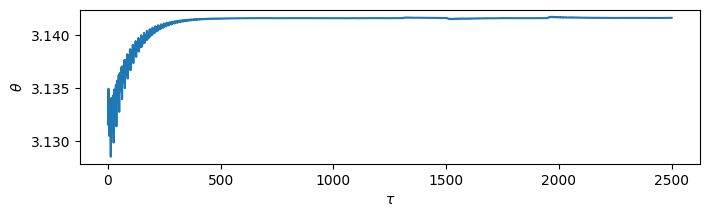

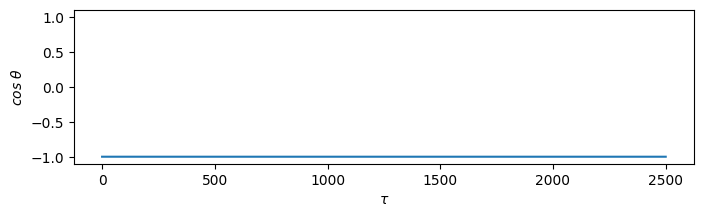

In [34]:
# input parameters
epsilon = 0.2
alpha = 0.3
zeta = 0.1

# number of decay times we want to integrate over
n_decay = 500

# define span of tau
tau_min = 0
tau_max = n_decay/(2*zeta)
tau_span = [tau_min, tau_max]

# define an initial state
delta_theta = 0.01 # deviation of theta from pi/inverted state
theta_0 = np.pi - delta_theta
ang_vel_0 = 0
y_0 = [theta_0, ang_vel_0]

# solve equation of motion
solution = solve_ivp(pivot_driven_pendulum,
                     tau_span, y_0,
                     args=(epsilon, alpha, zeta),
                     method='Radau',
                     dense_output=True)


# plot theta
tau_plot = np.linspace(tau_min, tau_max, 1000)
theta_plot = solution.sol(tau_plot)[0]

# plot theta
plt.figure(figsize=(8,2))
plt.plot(tau_plot, theta_plot)
plt.xlabel(r'$\tau$')
plt.ylabel(r'$\theta$')
# plt.ylim(-np.pi*1.1, np.pi*1.1)
plt.show()

# plot theta
plt.figure(figsize=(8,2))
plt.plot(tau_plot, np.cos(theta_plot))
plt.xlabel(r'$\tau$')
plt.ylabel(r'$cos\ \theta$')
plt.ylim(-1.1, 1.1)
plt.show()


### Pseudocode: integrate system and compute stability diagnostic

Given parameters $(\epsilon, \alpha, \zeta)$:

1. Set initial state near the inverted position:
   - $\theta_0 = \pi - \delta\theta$ (small deviation from the inverted position)
   - $\dot\theta_0 = 0$
   - $y_0 = [\theta_0, \dot\theta_0]$

2. Choose an integration window:
   - Pick a number of decay times `n_decay`
   - $\tau_\text{span} = [0, \text{n\_decay} / (2\zeta)]$

3. Integrate the ODE:
   - Use `solve_ivp(pivot_driven_pendulum, tau_span, y0, args=(epsilon, alpha, zeta), method="Radau")`

4. Sample the solution on a uniform $\tau$-grid.

5. Discard transients:
   - Throw away the first fraction (e.g. 50%) of the time series.

6. Compute a long-time stability diagnostic:
   - For the remaining $\theta(\tau)$, compute deviation from the inverted state
     $$\delta\theta(\tau) = \text{wrap\_to\_[-\pi,\pi]}(\theta(\tau) - \pi).$$
   - Define the RMS amplitude
     $$D = \sqrt{\langle \delta\theta(\tau)^2 \rangle}.$$

7. Classification:
   - If $D < \theta_\text{threshold}$ $\Rightarrow$ the inverted state is **stable**.
   - Otherwise $\Rightarrow$ **unstable**.


Example: epsilon=1.5, alpha=0.8, zeta=0.1
RMS deviation D = 3.142 rad; stable? False


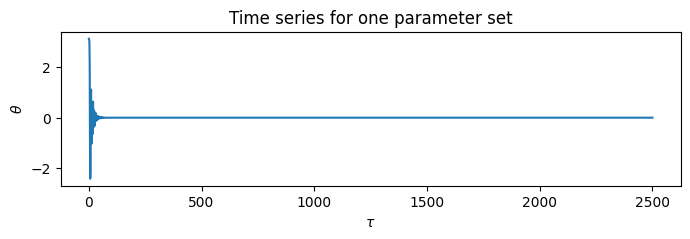

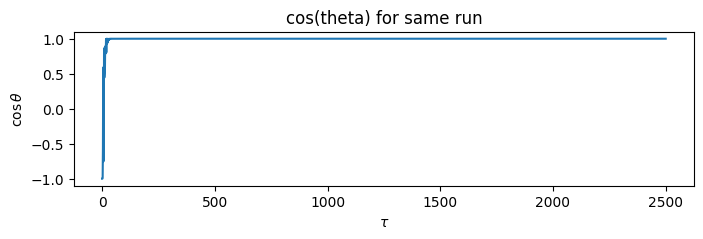

In [35]:
# ---------- helper: wrap angles to [-pi, pi] ----------
def wrap_angle(theta):
    """Map angles to the interval [-pi, pi].

    Parameters
    ----------
    theta : float or ndarray
        Input angle(s) in radians.

    Returns
    -------
    float or ndarray
        Angle(s) mapped into [-pi, pi].
    """
    return (theta + np.pi) % (2*np.pi) - np.pi


# ---------- integrate once and return time series ----------
def integrate_pendulum(epsilon, alpha, zeta,
                       n_decay=500,
                       n_samples=2000,
                       delta_theta=0.01):
    """Integrate the pivot-driven pendulum near the inverted state.

    Parameters
    ----------
    epsilon : float
        Dimensionless frequency (omega_0 / omega_d).
    alpha : float
        Dimensionless drive amplitude (y0 / l).
    zeta : float
        Dimensionless damping.
    n_decay : float, optional
        Number of decay times to integrate over.
    n_samples : int, optional
        Number of samples in the returned time series.
    delta_theta : float, optional
        Initial deviation from the inverted state (in radians).

    Returns
    -------
    tau : ndarray
        Sampled dimensionless time.
    theta : ndarray
        Angular position theta(tau).
    """
    # time span in tau units
    tau_min = 0.0
    tau_max = n_decay / (2*zeta)
    tau_span = [tau_min, tau_max]

    # initial conditions near inverted state
    theta_0 = np.pi - delta_theta
    ang_vel_0 = 0.0
    y_0 = [theta_0, ang_vel_0]

    sol = solve_ivp(
        pivot_driven_pendulum,
        tau_span, y_0,
        args=(epsilon, alpha, zeta),
        method='Radau',
        dense_output=True
    )

    tau = np.linspace(tau_min, tau_max, n_samples)
    theta = sol.sol(tau)[0]

    return tau, theta


# ---------- stability diagnostic ----------
def stability_measure(epsilon, alpha, zeta,
                      n_decay=500,
                      n_samples=2000,
                      frac_transient=0.5,
                      theta_threshold=0.3):
    """Compute an RMS deviation from the inverted state as a
    long-time stability diagnostic.

    Parameters
    ----------
    epsilon, alpha, zeta : float
        System parameters.
    n_decay : float, optional
        Number of decay times to integrate over.
    n_samples : int, optional
        Number of samples used in the RMS calculation.
    frac_transient : float, optional
        Fraction of the integration interval to discard as transient.
    theta_threshold : float, optional
        Threshold (radians) below which the inverted state is
        considered stable.

    Returns
    -------
    D : float
        RMS deviation of theta from pi over long times.
    is_stable : bool
        True if D < theta_threshold, else False.
    """
    tau, theta = integrate_pendulum(
        epsilon, alpha, zeta,
        n_decay=n_decay,
        n_samples=n_samples
    )

    # discard transients
    start_idx = int(frac_transient * len(tau))
    theta_tail = theta[start_idx:]

    # deviation from inverted state, wrapped to [-pi, pi]
    delta = wrap_angle(theta_tail - np.pi)

    # RMS amplitude
    D = np.sqrt(np.mean(delta**2))

    is_stable = D < theta_threshold
    return D, is_stable


# ---------- example single run + plot ----------
epsilon = 1.5
alpha   = 0.8
zeta    = 0.1

D_example, is_stable_example = stability_measure(epsilon, alpha, zeta)
print(f"Example: epsilon={epsilon}, alpha={alpha}, zeta={zeta}")
print(f"RMS deviation D = {D_example:.3f} rad; stable? {is_stable_example}")

tau_ex, theta_ex = integrate_pendulum(epsilon, alpha, zeta)

plt.figure(figsize=(8, 2))
plt.plot(tau_ex, theta_ex)
plt.xlabel(r"$\tau$")
plt.ylabel(r"$\theta$")
plt.title("Time series for one parameter set")
plt.show()

plt.figure(figsize=(8, 2))
plt.plot(tau_ex, np.cos(theta_ex))
plt.xlabel(r"$\tau$")
plt.ylabel(r"$\cos \theta$")
plt.ylim(-1.1, 1.1)
plt.title("cos(theta) for same run")
plt.show()


### Parameter sweep over $(\epsilon, \alpha)$

We now map out the long-time behavior of the inverted state for a fixed damping
$\zeta$ by sweeping over a grid of $(\epsilon, \alpha)$ values.

For each point on this grid we:

1. Integrate the equation of motion from an initial condition near the inverted state.
2. Discard an initial transient portion of the trajectory.
3. Compute the RMS deviation $D$ of $\theta$ from $\pi$.
4. Classify the state as *stable* if $D$ is below a chosen threshold.


In [28]:

# ---------- parameter sweep for one fixed zeta ----------

zeta_fixed = 0.1  # choose damping

epsilon_vals = np.linspace(0.5, 3.0, 30)   # x-axis
alpha_vals   = np.linspace(0.0, 3.0, 30)   # y-axis

D_map = np.zeros((len(alpha_vals), len(epsilon_vals)))
stable_map = np.zeros_like(D_map, dtype=bool)

for i, alpha in enumerate(alpha_vals):
    for j, epsilon in enumerate(epsilon_vals):
        D, is_stable = stability_measure(
            epsilon, alpha, zeta_fixed,
            n_decay=300,
            n_samples=1500,
            frac_transient=0.5,
            theta_threshold=0.3
        )
        D_map[i, j] = D
        stable_map[i, j] = is_stable

print("Parameter sweep complete.")


Parameter sweep complete.


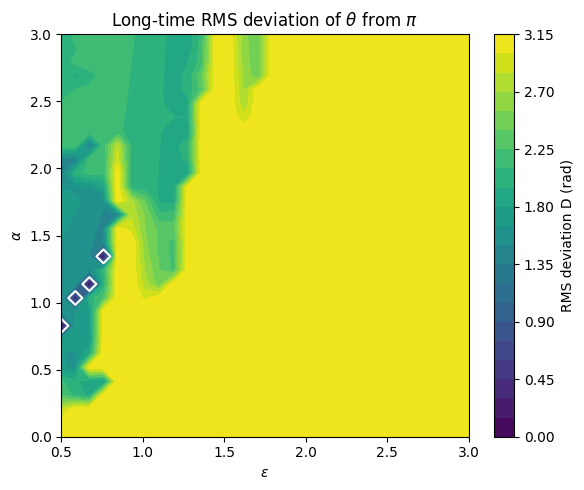

In [29]:

# ---------- 2D plot of RMS deviation D(alpha, epsilon) ----------

E_grid, A_grid = np.meshgrid(epsilon_vals, alpha_vals)

plt.figure(figsize=(6, 5))
cont = plt.contourf(E_grid, A_grid, D_map, levels=30)
cbar = plt.colorbar(cont)
cbar.set_label("RMS deviation D (rad)")

# overlay contour of the stable region (stable_map changes from 0 to 1)
plt.contour(E_grid, A_grid, stable_map,
            levels=[0.5], colors="w", linewidths=1.5)

plt.xlabel(r"$\epsilon$")
plt.ylabel(r"$\alpha$")
plt.title(r"Long-time RMS deviation of $\theta$ from $\pi$")
plt.tight_layout()
plt.show()


Fitted C ≈ 1.520


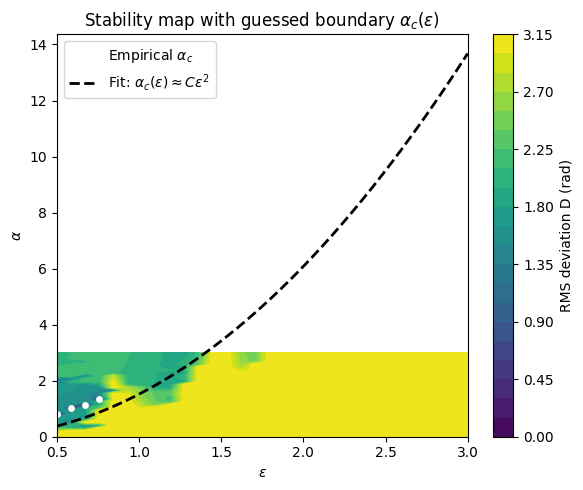

In [30]:

# ---------- estimate numerical alpha_c(epsilon) from the map ----------

alpha_crit_empirical = []

for j, epsilon in enumerate(epsilon_vals):
    # For this epsilon, look down the alpha column
    column_stable = stable_map[:, j]

    if not np.any(column_stable):
        # no stable points for this epsilon
        alpha_crit_empirical.append(np.nan)
        continue

    # smallest alpha that is stable
    alpha_candidates = alpha_vals[column_stable]
    alpha_crit_empirical.append(alpha_candidates.min())

alpha_crit_empirical = np.array(alpha_crit_empirical)

# keep only epsilons where we found a critical alpha
mask = ~np.isnan(alpha_crit_empirical)
eps_fit = epsilon_vals[mask]
alpha_fit = alpha_crit_empirical[mask]

# fit alpha_c ~ C * epsilon^2
C_fit = np.polyfit(eps_fit**2, alpha_fit, 1)[0]
print(f"Fitted C ≈ {C_fit:.3f}")

# define a smooth curve using the fitted C and existing alpha_critical function
eps_curve = np.linspace(epsilon_vals.min(), epsilon_vals.max(), 200)
alpha_curve = alpha_critical(eps_curve, zeta_fixed, C_fit)

plt.figure(figsize=(6, 5))
cont = plt.contourf(E_grid, A_grid, D_map, levels=30)
cbar = plt.colorbar(cont)
cbar.set_label("RMS deviation D (rad)")

# overlay empirical boundary points
plt.scatter(eps_fit, alpha_fit, color="white", s=15, label=r"Empirical $\alpha_c$")

# overlay fitted curve
plt.plot(eps_curve, alpha_curve, "k--", lw=2,
         label=r"Fit: $\alpha_c(\epsilon) \approx C \epsilon^2$")

plt.xlabel(r"$\epsilon$")
plt.ylabel(r"$\alpha$")
plt.title(r"Stability map with guessed boundary $\alpha_c(\epsilon)$")
plt.legend()
plt.tight_layout()
plt.show()



### Summary: stability criterion, numerical choices, and boundary fit

**Stability criterion.**  
I classify the inverted state as stable when the RMS deviation of the angle from
the inverted position,
\[
D = \sqrt{\langle (\delta\theta)^2 \rangle}, \qquad
\delta\theta = \text{wrap\_angle}(\theta - \pi),
\]
is less than a chosen threshold (here $\theta_\text{th} = 0.3$ rad).
The RMS is computed after discarding the first half of the simulation time so
that transients do not affect the diagnostic.

**Numerical parameters.**  
For each parameter pair $(\epsilon, \alpha)$ at fixed damping $\zeta = 0.1$
I integrate up to $\tau_\text{max} = \texttt{n\_decay}/(2\zeta)$, which
corresponds to several damping times, using `solve_ivp` with the Radau method.
I sample $\theta(\tau)$ on a uniform grid (1500–2000 points) and evaluate the
RMS deviation on the late-time data only. The parameter grid uses
$\epsilon \in [0.5, 3.0]$ and $\alpha \in [0, 3.0]$ with a 30×30 mesh,
which provides a smooth 2D map without being too expensive to compute.

**Functional form for the boundary.**  
From the stability map I extract, for each $\epsilon$, the smallest $\alpha$
for which the inverted state is stable. This gives an empirical critical curve
$\alpha_c(\epsilon)$. Motivated by the Kapitza theory (where the stabilizing
effect scales with drive amplitude times frequency squared), I fit these points
to the form
\[
\alpha_c(\epsilon) \approx C \, \epsilon^2.
\]
The fitted constant $C$ is reported in the code cell above. The resulting curve
$\alpha_c(\epsilon) = C\,\epsilon^2$ (dashed line) agrees reasonably well
with the numerically determined transition from unstable to stable behavior and
captures the overall trend that larger drive frequencies require larger drive
amplitudes to stabilize the inverted pendulum.
